In [ ]:
import cv2
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, MeanIoU
#!pip install tensorflow opencv-python-headless
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.metrics import MeanIoU
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy,Loss
from tensorflow.keras import backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/train_val.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/train_val.zip
   creating: train_val/
   creating: train_val/masks/
  inflating: train_val/masks/f_r_1912_.bmp  
  inflating: train_val/masks/f_r_1209_.bmp  
  inflating: train_val/masks/f_r_1764_.bmp  
  inflating: train_val/masks/f_r_658_.bmp  
  inflating: train_val/masks/w_r_98_.bmp  
  inflating: train_val/masks/f_r_2048_.bmp  
  inflating: train_val/masks/w_r_63_.bmp  
  inflating: train_val/masks/f_r_1656_.bmp  
  inflating: train_val/masks/f_r_1635_.bmp  
  inflating: train_val/masks/f_r_1831_.bmp  
  inflating: train_val/masks/f_r_171_.bmp  
  inflating: train_val/masks/d_r_1_.bmp  
  inflating: train_val/masks/f_r_1140_.bmp  
  inflating: train_val/masks/d_r_496_.bmp  
  inflating: train_val/masks/w_r_32_.bmp  
  inflating: train_val/masks/f_r_1392_.bmp  
  inflating: train_val/masks/w_r_119_.bmp  
  inflating: train_val/masks/f_r_1976_.bmp  
  inflating: train_val/masks/f_r_1108_.bmp  
  inflating: train_val/masks/d_r_740_.bmp

In [ ]:
import os
imgs_path='/content/train_val/images/'
imgs_files= os.listdir(imgs_path)
num_imgs = len(imgs_files)
masks_path='/content/train_val/masks/'
masks_files= os.listdir(masks_path)
num_masks = len(masks_files)
print(f'Total number of images: {num_imgs} and number of masks {num_masks}')

Total number of images: 1525 and number of masks 1525


# data

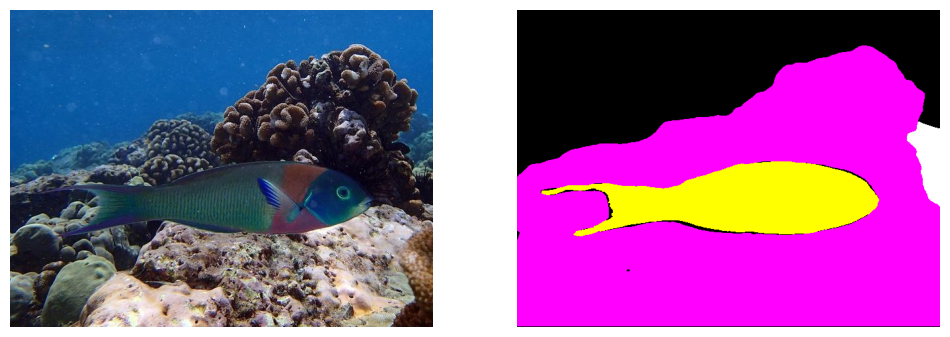

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
rr=random.choice(imgs_path)[:-4]
img=mpimg.imread(f'/content/train_val/images/{rr}.jpg')
mask=mpimg.imread(f'/content/train_val/masks/{rr}.bmp')
plt.figure(figsize=(12, 6))
plt.subplot(121).imshow(img)
plt.axis('off')
plt.subplot(122).imshow(mask)
plt.axis('off')
plt.show()

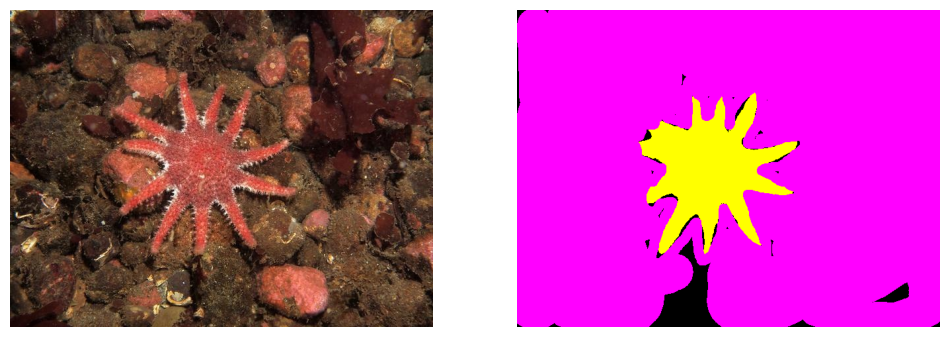

In [ ]:
rr=random.choice(imgs_path)[:-4]
img=mpimg.imread(f'/content/train_val/images/{rr}.jpg')
mask=mpimg.imread(f'/content/train_val/masks/{rr}.bmp')
plt.figure(figsize=(12, 6))
plt.subplot(121).imshow(img)
plt.axis('off')
plt.subplot(122).imshow(mask)
plt.axis('off')
plt.show()

# Normalization

**Standardization (Z-score Normalization)**:  This method transforms the data to have a mean (µ) of 0 and a standard deviation (σ) of 1. It helps in stabilizing the variance and making the features more comparable.
- Standardization can be effective if the dataset has varying lighting conditions. It helps in normalizing the contrast and brightness across different images.

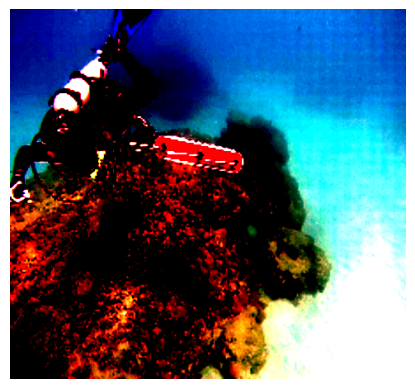

In [ ]:
image = cv2.imread('/content/train_val/images/d_r_113_.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

def standardize_image(image):
    mean = np.mean(image, axis=(0, 1), keepdims=True)
    std = np.std(image, axis=(0, 1), keepdims=True)
    standardized = (image - mean) / std
    return np.clip(standardized, -1, 1)
plt.imshow(standardize_image(image))
plt.axis('off')
plt.show()

**Min-Max Normalization**: This method scales the data to a fixed range, usually [0, 1] or [-1, 1].
- Min-Max normalization is useful when we want to preserve the relationships between the values. It can be particularly helpful when the pixel values are in different ranges due to varying water clarity and light penetration.

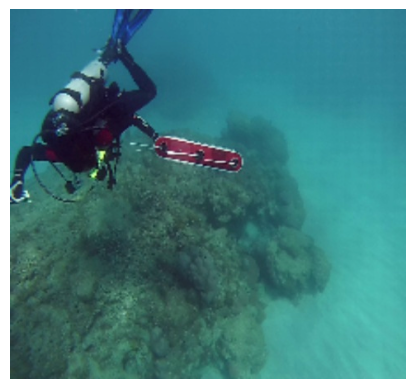

In [ ]:
def min_max_normalize_image(image):
    min_val = np.min(image, axis=(0, 1), keepdims=True)
    max_val = np.max(image, axis=(0, 1), keepdims=True)
    normalized = (image - min_val) / (max_val - min_val)
    return np.clip(normalized, 0, 1)
plt.imshow(min_max_normalize_image(image))
plt.axis('off')
plt.show()

**Histogram Equalization**: This technique adjusts the contrast of the image by modifying the intensity distribution. It spreads out the most frequent intensity values, improving the global contrast.
- Underwater images often suffer from low contrast and varying brightness. Histogram equalization can enhance the visibility of objects by improving the contrast.

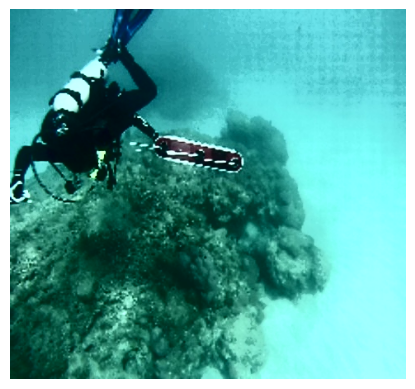

In [ ]:
def histogram_equalization_image(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    image_yuv[:,:,0] = cv2.equalizeHist(image_yuv[:,:,0])
    equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return equalized
plt.imshow(histogram_equalization_image(image))
plt.axis('off')
plt.show()

**Adaptive Histogram Equalization (AHE)**: A variant of histogram equalization, AHE improves contrast by dividing the image into smaller regions and applying histogram equalization to each region separately.
- AHE is particularly effective for images with local variations in illumination, which is common in underwater environments due to light scattering and absorption.

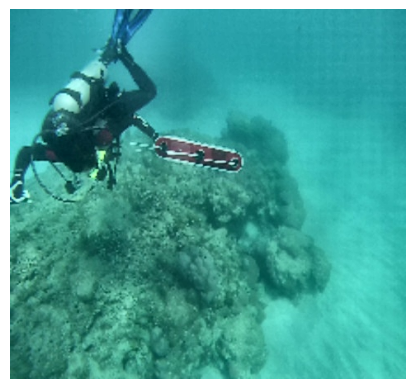

In [ ]:
def adaptive_histogram_equalization_image(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    ahe_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return ahe_equalized
plt.imshow(adaptive_histogram_equalization_image(image))
plt.axis('off')
plt.show()

**CLAHE (Contrast Limited Adaptive Histogram Equalization)**:
CLAHE is a form of adaptive histogram equalization that prevents over-amplification of noise by limiting the contrast enhancement.
- CLAHE is suitable for underwater images where noise can be a significant issue. It enhances local contrast without amplifying noise excessively.


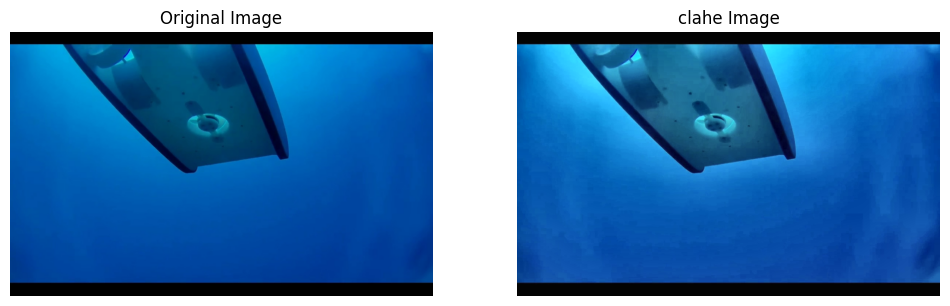

In [ ]:
def clahe_image(image):
    image_yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image_yuv[:,:,0] = clahe.apply(image_yuv[:,:,0])
    clahe_equalized = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
    return clahe_equalized
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
clahe_image_ = clahe_image(image)
plt.subplot(122)
plt.imshow(clahe_image_)
plt.title('clahe Image')
plt.axis('off')
plt.show()

**Color Normalization (White Balance Correction)**
: This method adjusts the color balance of an image, correcting for color distortions due to water absorption and scattering.
- Underwater images often have a bluish or greenish tint. White balance correction helps in restoring natural colors, making objects more distinguishable.

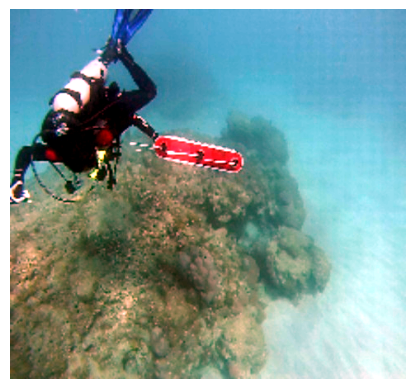

In [ ]:
def white_balance_image(image):
    result = cv2.xphoto.createSimpleWB().balanceWhite(image)
    return result
plt.imshow(white_balance_image(image))
plt.axis('off')
plt.show()

**Gamma Correction**: Gamma correction adjusts the luminance of the image, enhancing the mid-tones while preserving shadows and highlights.
- It is useful for correcting lighting conditions in underwater images, making the features more prominent.

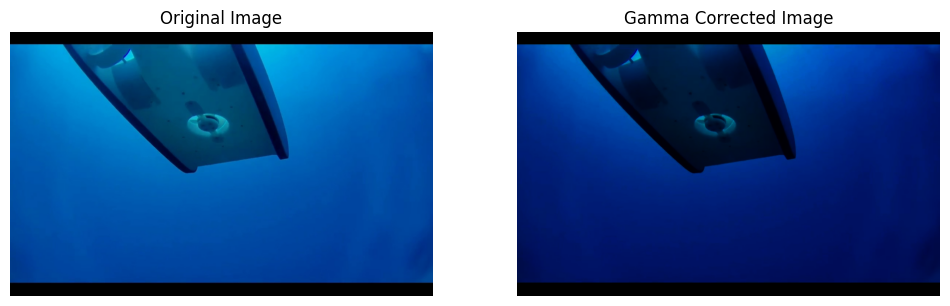

In [ ]:
def gamma_correction_image(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    gamma_corrected = cv2.LUT(image, table)
    return gamma_corrected

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image')
plt.axis('off')
gamma_corrected_image = gamma_correction_image(image, gamma=0.5)
plt.subplot(122)
plt.imshow(gamma_corrected_image)
plt.title('Gamma Corrected Image')
plt.axis('off')
plt.show()

Recommended Approach
A combination of the above techniques often yields the best results for underwater imagery. Here’s a possible pipeline:

- **White Balance Correction**: To correct color distortions and make the colors more natural.
- **Gamma Correction**: To enhance the mid-tones and improve visibility.
- **CLAHE**: To enhance local contrast without amplifying noise excessively.


White Balance Correction addresses color distortions due to water absorption and scattering.
Gamma Correction improves the visibility of mid-tones, which are crucial for distinguishing objects underwater.
CLAHE enhances local contrast, making the objects stand out more clearly without excessively amplifying noise.

In [ ]:
standardized_image = standardize_image(image)
min_max_normalized_image = min_max_normalize_image(image)
histogram_equalized_image = histogram_equalization_image(image)
ahe_equalized_image = adaptive_histogram_equalization_image(image)
clahe_image = clahe_image(image)
white_balanced_image = white_balance_image(image)
gamma_corrected_image = gamma_correction_image(image, gamma=1)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.ravel()
titles = ['Original','Standardized','Min-Max Normalized','Histogram Equalized',
          'AHE Equalized','CLAHE','White Balanced','Gamma Corrected']
images = [image, standardized_image, min_max_normalized_image,
          histogram_equalized_image, ahe_equalized_image, clahe_image,
          white_balanced_image, gamma_corrected_image]
for i in range(len(images)):
    axes[i].imshow(images[i])
    axes[i].set_title(titles[i])
    axes[i].axis('off')
plt.tight_layout()
plt.show()

NameError: name 'standardize_image' is not defined

# on the fly normalization

In [ ]:
! pip install tensorflow opencv-python-headless
import tensorflow as tf
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models


class WhiteBalanceLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        inputs = tf.cast(inputs, tf.uint8)
        outputs = tf.numpy_function(self.white_balance, [inputs], tf.uint8)
        outputs = tf.cast(outputs, tf.float32) / 255.0
        return outputs

    def white_balance(self, image):
        result = cv2.xphoto.createSimpleWB().balanceWhite(image)
        return result

class GammaCorrectionLayer(tf.keras.layers.Layer):
    def __init__(self, gamma=1.5, **kwargs):
        super(GammaCorrectionLayer, self).__init__(**kwargs)
        self.gamma = gamma

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.uint8)
        outputs = tf.numpy_function(self.gamma_correction, [inputs], tf.uint8)
        outputs = tf.cast(outputs, tf.float32) / 255.0
        return outputs

    def gamma_correction(self, image):
        inv_gamma = 1.0 / self.gamma
        table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
        gamma_corrected = cv2.LUT(image, table)
        return gamma_corrected

class CLAHELayer(tf.keras.layers.Layer):
    def call(self, inputs):
        inputs = tf.cast(inputs, tf.uint8)
        outputs = tf.numpy_function(self.clahe, [inputs], tf.uint8)
        outputs = tf.cast(outputs, tf.float32) / 255.0
        return outputs

    def clahe(self, image):
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(image_lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        l_clahe = clahe.apply(l)
        image_clahe = cv2.merge((l_clahe, a, b))
        image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)
        return image_clahe
def build_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)
    x = WhiteBalanceLayer()(inputs)
    x = GammaCorrectionLayer(gamma=1.5)(x)
    x = CLAHELayer()(x)

    # Add your model architecture here
    # For example:
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    return model

# Define the input shape and number of classes
input_shape = (height, width, channels)  # e.g., (128, 128, 3)
num_classes = 10  # Number of classes for your segmentation task

# Build and compile the model
model = build_model(input_shape)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.utils import to_categorical
import segmentation_models as sm

def Z_pool(x):
    max_pool = K.max(x, axis=1, keepdims=True)
    avg_pool = K.mean(x, axis=1, keepdims=True)
    return K.concatenate([max_pool, avg_pool], axis=1)

def triplet_attention(input_tensor):
    C, H, W = input_tensor.shape[-3], input_tensor.shape[-2], input_tensor.shape[-1]

    def branch(input_tensor, axis1, axis2):
        x = tf.transpose(input_tensor, [axis1, axis2, 0])  # Rotate
        x = layers.Lambda(Z_pool)(x)
        x = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('sigmoid')(x)
        x = tf.transpose(x, [2, 1, 0])  # Rotate back
        return x

    T1 = branch(input_tensor, 2, 1)  # (W, H, C)
    T2 = branch(input_tensor, 1, 0)  # (H, C, W)

    x = layers.Lambda(Z_pool)(input_tensor)
    T3 = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
    T3 = layers.BatchNormalization()(T3)
    T3 = layers.Activation('sigmoid')(T3)

    output = layers.Add()([T1, T2, T3])
    output = layers.Average()(output)
    return output

def build_ta_unet(input_shape, num_classes):
    inputs = Input(input_shape)
    s = inputs

    # Encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = triplet_attention(c2)  # Add triplet attention
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = triplet_attention(c3)  # Add triplet attention
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = triplet_attention(c4)  # Add triplet attention
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape and number of classes
IMG_HEIGHT = 368
IMG_WIDTH = 640
IMG_CHANNELS = 3
NUM_CLASSES = 8
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_ta_unet(input_shape, NUM_CLASSES)

# Define combined loss function
lovasz_loss = sm.losses.LovaszSoftmax()
def combined_loss(y_true, y_pred):
    return lovasz_loss(y_true, y_pred) + tf.keras.losses.categorical_crossentropy(y_true, y_pred)

# Compile the model
model.compile(optimizer='adam', loss=combined_loss, metrics=['accuracy', mean_iou])

# Assuming X_train and y_train are your training data
# Ensure y_train is one-hot encoded
y_train = to_categorical(y_train, num_classes=NUM_CLASSES)

# Fit the model
results = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=100)

# Print the model summary
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.utils import to_categorical

def Z_pool(x):
    max_pool = K.max(x, axis=1, keepdims=True)
    avg_pool = K.mean(x, axis=1, keepdims=True)
    return K.concatenate([max_pool, avg_pool], axis=1)

def triplet_attention(input_tensor):
    C, H, W = input_tensor.shape[-3], input_tensor.shape[-2], input_tensor.shape[-1]

    def branch(input_tensor, axis1, axis2):
        x = tf.transpose(input_tensor, [axis1, axis2, 0])  # Rotate
        x = layers.Lambda(Z_pool)(x)
        x = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('sigmoid')(x)
        x = tf.transpose(x, [2, 1, 0])  # Rotate back
        return x

    T1 = branch(input_tensor, 2, 1)  # (W, H, C)
    T2 = branch(input_tensor, 1, 0)  # (H, C, W)

    x = layers.Lambda(Z_pool)(input_tensor)
    T3 = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
    T3 = layers.BatchNormalization()(T3)
    T3 = layers.Activation('sigmoid')(T3)

    output = layers.Add()([T1, T2, T3])
    output = layers.Average()(output)
    return output

def build_ta_unet(input_shape, num_classes):
    inputs = Input(input_shape)
    s = inputs

    # Encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = triplet_attention(c2)  # Add triplet attention
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = triplet_attention(c3)  # Add triplet attention
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = triplet_attention(c4)  # Add triplet attention
    p4 = MaxPooling2D((2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Decoding
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(num_classes, (1, 1), activation='softmax')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Define input shape and number of classes
IMG_HEIGHT = 368
IMG_WIDTH = 640
IMG_CHANNELS = 3
NUM_CLASSES = 8
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)
model = build_ta_unet(input_shape, NUM_CLASSES)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assuming X_train and y_train are your training data
# Ensure y_train is one-hot encoded
y_train = to_categorical(masks_train, num_classes=NUM_CLASSES)

# Fit the model
results = model.fit(images_train, masks_train, validation_split=0.1, batch_size=16, epochs=100)

# Print the model summary
model.summary()


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

def Z_pool(x):
    max_pool = K.max(x, axis=1, keepdims=True)
    avg_pool = K.mean(x, axis=1, keepdims=True)
    return K.concatenate([max_pool, avg_pool], axis=1)

def triplet_attention(input_tensor):
    C, H, W = input_tensor.shape[-3], input_tensor.shape[-2], input_tensor.shape[-1]

    def branch(input_tensor, axis1, axis2):
        x = tf.transpose(input_tensor, [axis1, axis2, 0])  # Rotate
        x = layers.Lambda(Z_pool)(x)
        x = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('sigmoid')(x)
        x = tf.transpose(x, [2, 1, 0])  # Rotate back
        return x

    T1 = branch(input_tensor, 2, 1)  # (W, H, C)
    T2 = branch(input_tensor, 1, 0)  # (H, C, W)

    x = layers.Lambda(Z_pool)(input_tensor)
    T3 = layers.Conv2D(1, kernel_size=(1, 1), padding='same')(x)
    T3 = layers.BatchNormalization()(T3)
    T3 = layers.Activation('sigmoid')(T3)

    output = layers.Add()([T1, T2, T3])
    output = layers.Average()(output)
    return output

def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, filters, apply_attention=True):
    x = conv_block(x, filters)
    if apply_attention:
        x = triplet_attention(x)
    p = layers.MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(x, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, filters)
    return x

def build_ta_unet(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64, apply_attention=False)  # No attention in the first block
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bottleneck
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)

    model = models.Model(inputs, outputs)
    return model

# Define input shape and build the model
input_shape = (368, 640, 3)  # Assuming input images are 368x640 with 3 channels
model = build_ta_unet(input_shape)

# Print the model summary
model.summary()


# Train

#UNET : cross entropy loss

In [ ]:
def white_balance(image):
    result = cv2.xphoto.createSimpleWB().balanceWhite(image)
    return result

def gamma_correction(image, gamma=1):
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    image = image.astype(np.uint8)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    gamma_corrected = cv2.LUT(image, table)
    return gamma_corrected

def clahe(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    image_clahe = cv2.merge((l_clahe, a, b))
    image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)
    return image_clahe

def preprocess_image(image):
    image = tf.numpy_function(white_balance, [image], tf.uint8)
    image = tf.numpy_function(gamma_correction, [image], tf.uint8)
    image = tf.numpy_function(clahe, [image], tf.uint8)
    image = tf.cast(image, tf.float32) #/ 255.0  # Normalize to [0, 1]
    return image

def load_and_preprocess_image(img_path, target_size):
    image = img_to_array(load_img(img_path, target_size=target_size))
    image = preprocess_image(image)
    return image

def resize_mask(mask, target_shape):
    mask_resized = cv2.resize(mask, target_shape, interpolation=cv2.INTER_NEAREST)
    return mask_resized

def one_hot_encode_mask(mask, num_classes):
    one_hot_mask = np.zeros((*mask.shape, num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot_mask[:, :, c] = (mask == c).astype(np.float32)
    return one_hot_mask

class DataGenerator(Sequence):
    def __init__(self, img_files, mask_files, imgs_path, masks_path, batch_size=32, img_size=(640, 368), shuffle=True, num_classes=8):
        self.img_files = img_files
        self.mask_files = mask_files
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        img_files_temp = [self.img_files[k] for k in indexes]
        mask_files_temp = [self.mask_files[k] for k in indexes]
        X, y = self.__data_generation(img_files_temp, mask_files_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_files_temp, mask_files_temp):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.img_size, self.num_classes), dtype=np.float32)

        for i, (img_file, mask_file) in enumerate(zip(img_files_temp, mask_files_temp)):
            img_path = os.path.join(self.imgs_path, img_file)
            mask_path = os.path.join(self.masks_path, mask_file)

            image = load_and_preprocess_image(img_path, target_size=self.img_size)
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize_mask(mask, self.img_size[::-1])  # Resizing mask to match target size

            # Ensure mask values are within the range [0, num_classes - 1]
            mask = np.clip(mask, 0, self.num_classes - 1)

            # Convert to one-hot encoding
            mask = tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

            X[i, ] = image
            y[i, ] = mask

        return X, y

train_imgs_files, val_imgs_files, train_masks_files, val_masks_files = train_test_split(
    imgs_files, masks_files, test_size=0.1, random_state=2)

batch_size = 32
img_size = (640, 368)

train_generator = DataGenerator(train_imgs_files, train_masks_files, imgs_path, masks_path, batch_size=batch_size, img_size=img_size)
val_generator = DataGenerator(val_imgs_files, val_masks_files, imgs_path, masks_path, batch_size=batch_size)

def UNET(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    s = inputs
    # Encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Decoding
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(c9)
    logits = Conv2D(num_classes, (1, 1), padding='same')(c9)  # Use logits for dice loss computation

    model = Model(inputs, outputs)
    return model, logits

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, logits):
    y_pred = tf.nn.softmax(logits)
    return 1 - dice_coefficient(y_true, y_pred)


def combined_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, logits)


input_shape = (*img_size, 3)
num_classes = 8
model, logits = UNET(input_shape, num_classes)

#model = UNET(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',mean_iou])

history1=model.fit(train_generator, validation_data=val_generator, epochs=15)

NameError: name 'mean_iou' is not defined

In [ ]:
len(epochs)

15

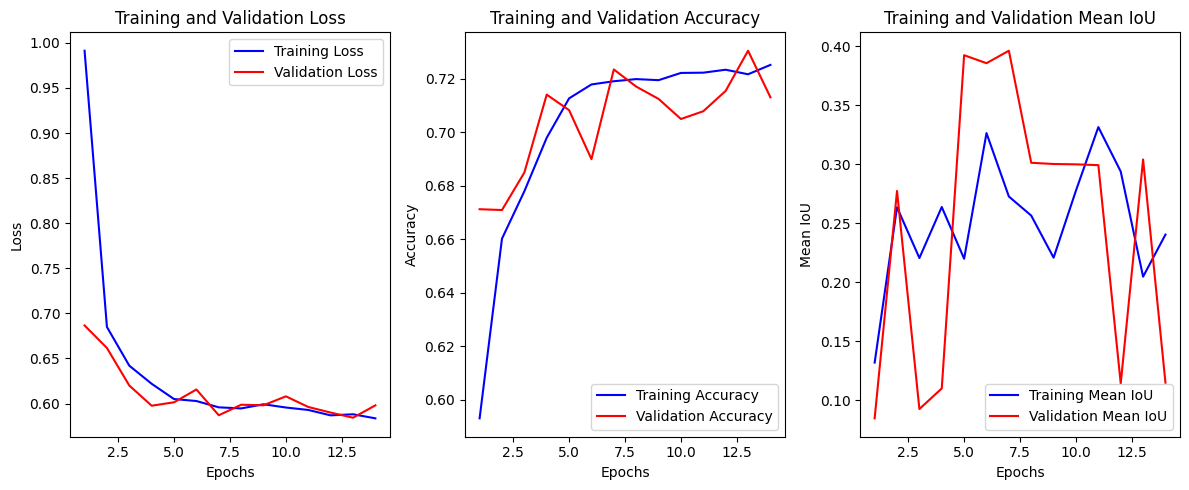

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
plt.plot(history1.history['mean_iou'])
plt.plot(history1.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from keras import backend as K
def mean_iou(y_true, y_pred):
    num_classes = 8
    iou = []
    for i in range(num_classes):
        true = K.cast(K.flatten(K.equal(y_true[..., i], 1)), dtype='float32')
        pred = K.cast(K.flatten(K.equal(K.argmax(y_pred, axis=-1), i)), dtype='float32')
        intersection = K.sum(true * pred)
        union = K.sum(true) + K.sum(pred) - intersection
        iou.append((intersection + K.epsilon()) / (union + K.epsilon()))
    return K.mean(K.stack(iou), axis=0)

In [ ]:
import tensorflow as tf
from keras import backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.nn.softmax(y_pred)
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


# UNET :dice loss

In [ ]:
def white_balance(image):
    result = cv2.xphoto.createSimpleWB().balanceWhite(image)
    return result

def gamma_correction(image, gamma=1):
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    image = image.astype(np.uint8)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    gamma_corrected = cv2.LUT(image, table)
    return gamma_corrected

def clahe(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    image_clahe = cv2.merge((l_clahe, a, b))
    image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)
    return image_clahe

def preprocess_image(image):
    image = tf.numpy_function(white_balance, [image], tf.uint8)
    image = tf.numpy_function(gamma_correction, [image], tf.uint8)
    image = tf.numpy_function(clahe, [image], tf.uint8)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image

def load_and_preprocess_image(img_path, target_size):
    image = img_to_array(load_img(img_path, target_size=target_size))
    image = preprocess_image(image)
    return image

def resize_mask(mask, target_shape):
    mask_resized = cv2.resize(mask, target_shape, interpolation=cv2.INTER_NEAREST)
    return mask_resized

def one_hot_encode_mask(mask, num_classes):
    one_hot_mask = np.zeros((*mask.shape, num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot_mask[:, :, c] = (mask == c).astype(np.float32)
    return one_hot_mask

class DataGenerator(Sequence):
    def __init__(self, img_files, mask_files, imgs_path, masks_path, batch_size=32, img_size=(640, 368), shuffle=True, num_classes=8):
        self.img_files = img_files
        self.mask_files = mask_files
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        img_files_temp = [self.img_files[k] for k in indexes]
        mask_files_temp = [self.mask_files[k] for k in indexes]
        X, y = self.__data_generation(img_files_temp, mask_files_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_files_temp, mask_files_temp):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.img_size, self.num_classes), dtype=np.float32)

        for i, (img_file, mask_file) in enumerate(zip(img_files_temp, mask_files_temp)):
            img_path = os.path.join(self.imgs_path, img_file)
            mask_path = os.path.join(self.masks_path, mask_file)

            image = load_and_preprocess_image(img_path, target_size=self.img_size)
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize_mask(mask, self.img_size[::-1])  # Resizing mask to match target size

            # Ensure mask values are within the range [0, num_classes - 1]
            mask = np.clip(mask, 0, self.num_classes - 1)

            # Convert to one-hot encoding
            mask = tf.keras.utils.to_categorical(mask, num_classes=self.num_classes)

            X[i, ] = image
            y[i, ] = mask

        return X, y

train_imgs_files, val_imgs_files, train_masks_files, val_masks_files = train_test_split(
    imgs_files, masks_files, test_size=0.1, random_state=2)

batch_size = 32
img_size = (640, 368)

train_generator = DataGenerator(train_imgs_files, train_masks_files, imgs_path, masks_path, batch_size=batch_size, img_size=img_size)
val_generator = DataGenerator(val_imgs_files, val_masks_files, imgs_path, masks_path, batch_size=batch_size)

def UNET(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    s = inputs
    # Encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Decoding
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    #outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(c9)
    outputs = Conv2D(num_classes, (1, 1), padding='same')(c9)  # Use logits for dice loss computation

    model = Model(inputs, outputs)
    return model

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, logits):
    y_pred = tf.nn.softmax(logits)
    return 1 - dice_coefficient(y_true, y_pred)


def combined_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, logits)


input_shape = (*img_size, 3)
num_classes = 8
model = UNET(input_shape, num_classes)
model.compile(optimizer='adam',
              loss=dice_loss,
              metrics=['accuracy',mean_iou])

history1=model.fit(train_generator, validation_data=val_generator, epochs=15)

Epoch 1/15
42/42 [==============================] - 150s 3s/step - loss: 0.3548 - accuracy: 0.6445 - mean_iou: 0.1090 - val_loss: 0.3325 - val_accuracy: 0.6675 - val_mean_iou: 0.2397
Epoch 2/15
42/42 [==============================] - 121s 3s/step - loss: 0.3106 - accuracy: 0.6894 - mean_iou: 0.1159 - val_loss: 0.3330 - val_accuracy: 0.6670 - val_mean_iou: 0.2396
Epoch 3/15
42/42 [==============================] - 125s 3s/step - loss: 0.3112 - accuracy: 0.6888 - mean_iou: 0.1099 - val_loss: 0.3293 - val_accuracy: 0.6707 - val_mean_iou: 0.2401
Epoch 4/15
42/42 [==============================] - 122s 3s/step - loss: 0.3107 - accuracy: 0.6893 - mean_iou: 0.1070 - val_loss: 0.3289 - val_accuracy: 0.6711 - val_mean_iou: 0.2401
Epoch 5/15
42/42 [==============================] - 121s 3s/step - loss: 0.3086 - accuracy: 0.6914 - mean_iou: 0.1251 - val_loss: 0.3304 - val_accuracy: 0.6696 - val_mean_iou: 0.2399
Epoch 6/15
42/42 [==============================] - 121s 3s/step - loss: 0.3085 - acc

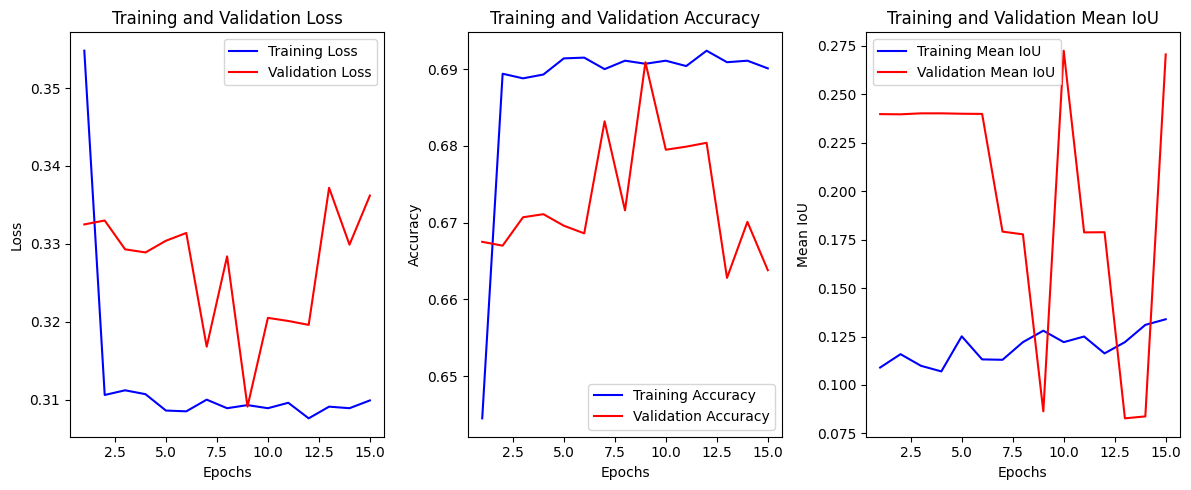

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
plt.plot(history1.history['mean_iou'])
plt.plot(history1.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


# UNET :**combined loss**

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
# pre processing
def white_balance(image):
    result = cv2.xphoto.createSimpleWB().balanceWhite(image)
    return result

def gamma_correction(image, gamma=1):
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    image = image.astype(np.uint8)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    gamma_corrected = cv2.LUT(image, table)
    return gamma_corrected

def clahe(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    image_clahe = cv2.merge((l_clahe, a, b))
    image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)
    return image_clahe

def preprocess_image(image):
    image = tf.numpy_function(white_balance, [image], tf.uint8)
    image = tf.numpy_function(gamma_correction, [image], tf.uint8)
    image = tf.numpy_function(clahe, [image], tf.uint8)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_preprocess_image(img_path, target_size):
    image = img_to_array(load_img(img_path, target_size=target_size))
    image = preprocess_image(image)
    return image

def resize_mask(mask, target_shape):
    mask_resized = cv2.resize(mask, target_shape, interpolation=cv2.INTER_NEAREST)
    return mask_resized

def one_hot_encode_mask(mask, num_classes):
    one_hot_mask = np.zeros((*mask.shape, num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot_mask[:, :, c] = (mask == c).astype(np.float32)
    return one_hot_mask

# Data augmentation
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

class DataGenerator(Sequence):
    def __init__(self, img_files, mask_files, imgs_path, masks_path, batch_size=32, img_size=(640, 368), shuffle=True, num_classes=8):
        self.img_files = img_files
        self.mask_files = mask_files
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        img_files_temp = [self.img_files[k] for k in indexes]
        mask_files_temp = [self.mask_files[k] for k in indexes]
        X, y = self.__data_generation(img_files_temp, mask_files_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_files_temp, mask_files_temp):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.img_size, self.num_classes), dtype=np.float32)

        for i, (img_file, mask_file) in enumerate(zip(img_files_temp, mask_files_temp)):
            img_path = os.path.join(self.imgs_path, img_file)
            mask_path = os.path.join(self.masks_path, mask_file)

            image = load_and_preprocess_image(img_path, target_size=self.img_size)
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize_mask(mask, self.img_size[::-1])
            mask = np.clip(mask, 0, self.num_classes - 1)
            mask = one_hot_encode_mask(mask, self.num_classes)

            # augmentation here
            augmented = image_datagen.flow(np.expand_dims(image, axis=0), batch_size=1, seed=42)[0]
            mask_augmented = mask_datagen.flow(np.expand_dims(mask, axis=0), batch_size=1, seed=42)[0]

            X[i, ] = augmented[0]
            y[i, ] = mask_augmented[0]

        return X, y

train_imgs_files, val_imgs_files, train_masks_files, val_masks_files = train_test_split(
    imgs_files, masks_files, test_size=0.1, random_state=2)

batch_size = 16
img_size = (640, 368)

train_generator = DataGenerator(train_imgs_files, train_masks_files, imgs_path, masks_path, batch_size=batch_size, img_size=img_size)
val_generator = DataGenerator(val_imgs_files, val_masks_files, imgs_path, masks_path, batch_size=batch_size)

def UNET(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    s = inputs
    # Encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Decoding
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    #outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(c9)
    outputs = Conv2D(num_classes, (1, 1), padding='same')(c9)

    model = Model(inputs, outputs)
    return model

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, logits):
    y_pred = tf.nn.softmax(logits)
    return 1 - dice_coefficient(y_true, y_pred)



def combined_loss(y_true, logits):
  y_pred = tf.nn.softmax(logits)
  return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, logits)
  #return tf.keras.losses.categorical_crossentropy(y_true, tf.nn.softmax(y_pred)) + dice_loss(y_true, logits)


checkpoint_dir = '/content/drive/My Drive/ModelCheckpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'), monitor='val_loss', save_best_only=False, mode='min', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0005, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

input_shape = (*img_size, 3)
num_classes = 8
model = UNET(input_shape, num_classes)
model.compile(optimizer='adam',
              loss=combined_loss,
              metrics=['accuracy', mean_iou])

history3 = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    callbacks=[checkpoint, reduce_lr, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 640, 368, 8) (8 channels).
  warnings.warn(


Epoch 1/20
85/85 [==============================] - ETA: 0s - loss: 1.2937 - accuracy: 0.6535 - mean_iou: 0.4246

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 430s 5s/step - loss: 1.2937 - accuracy: 0.6535 - mean_iou: 0.4246 - val_loss: 1.0961 - val_accuracy: 0.6753 - val_mean_iou: 0.5980 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 405s 5s/step - loss: 1.0266 - accuracy: 0.7077 - mean_iou: 0.5332 - val_loss: 1.0029 - val_accuracy: 0.7153 - val_mean_iou: 0.6262 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 385s 5s/step - loss: 0.9966 - accuracy: 0.7216 - mean_iou: 0.5526 - val_loss: 0.9848 - val_accuracy: 0.7163 - val_mean_iou: 0.6271 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 387s 5s/step - loss: 0.9706 - accuracy: 0.7257 - mean_iou: 0.5564 - val_loss: 0.9836 - val_accuracy: 0.7164 - val_mean_iou: 0.6272 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 395s 5s/step - loss: 0.9693 - accuracy: 0.7270 - mean_iou: 0.5570 - val_loss: 0.9850 - val_accuracy: 0.7165 - val_mean_iou: 0.6273 - lr: 0.0010
Epoch 6/20
85/85 [=============

In [ ]:
model.save('/content/drive/MyDrive/my_model.h5')


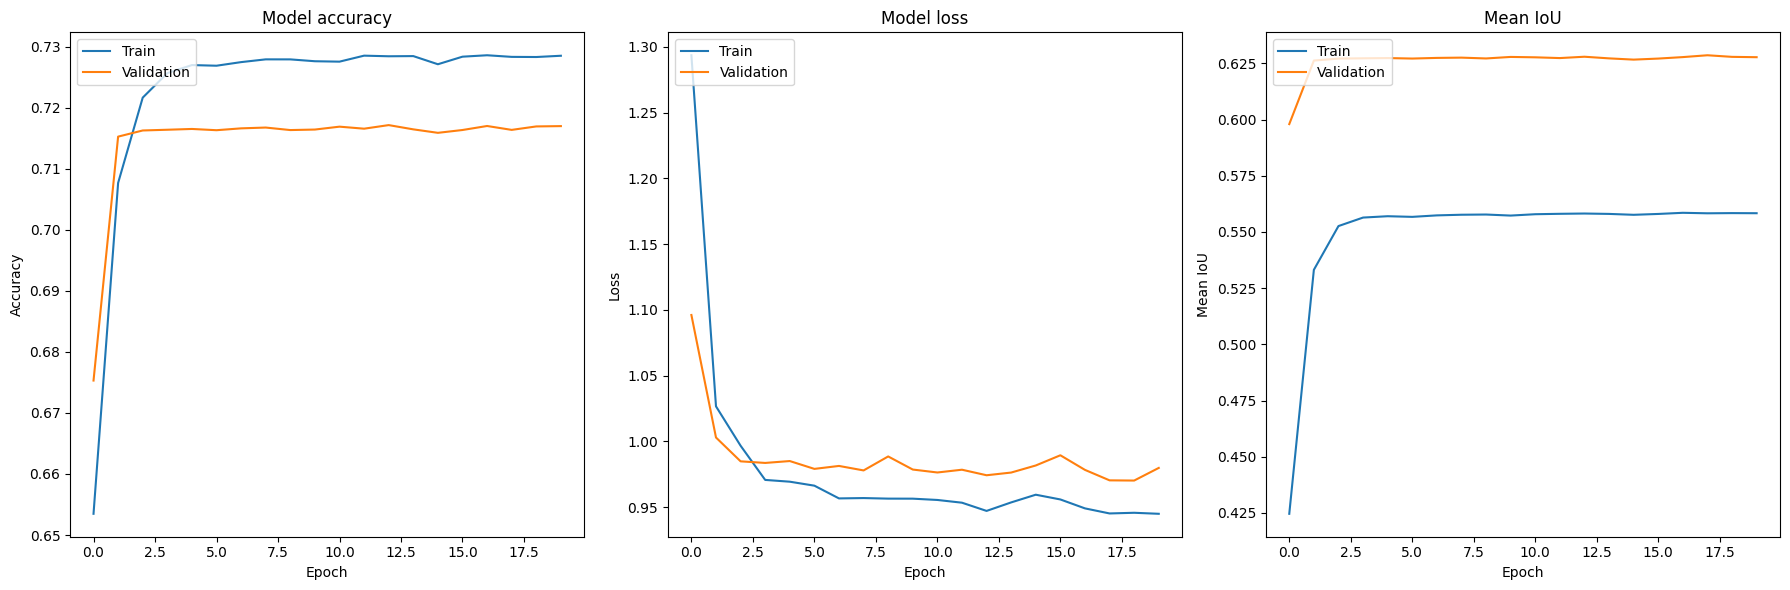

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history3.history['mean_iou'])
plt.plot(history3.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# TA UNET

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, concatenate
from tensorflow.keras import backend as K
def mean_pool(x):
    return K.mean(x, axis=-1, keepdims=True)
def max_pool(x):
    return K.max(x, axis=-1, keepdims=True)
def attention_block(x, filters):
    avg_poool = tf.keras.layers.Lambda(mean_pool)(x)
    max_poool = tf.keras.layers.Lambda(max_pool)(x)
    concat = concatenate([avg_poool, max_poool], axis=-1)
    conv = Conv2D(filters, (1, 1), activation='sigmoid', padding='same')(concat)
    return conv
def triplet_attention(x, filters):
    input_shape = K.int_shape(x)
    x1 = tf.image.rot90(x, k=1)
    x1 = attention_block(x1, filters)
    x1 = tf.image.rot90(x1, k=3)
    x2 = tf.image.rot90(x, k=2)
    x2 = attention_block(x2, filters)
    x2 = tf.image.rot90(x2, k=2)
    x3 = attention_block(x, filters)
    output = (x1 + x2 + x3) / 3
    return output

In [ ]:
def white_balance(image):
    result = cv2.xphoto.createSimpleWB().balanceWhite(image)
    return result

def gamma_correction(image, gamma=1):
    if isinstance(image, tf.Tensor):
        image = image.numpy()
    image = image.astype(np.uint8)
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    gamma_corrected = cv2.LUT(image, table)
    return gamma_corrected

def clahe(image):
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(image_lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l_clahe = clahe.apply(l)
    image_clahe = cv2.merge((l_clahe, a, b))
    image_clahe = cv2.cvtColor(image_clahe, cv2.COLOR_LAB2RGB)
    return image_clahe

def preprocess_image(image):
    image = tf.numpy_function(white_balance, [image], tf.uint8)
    image = tf.numpy_function(gamma_correction, [image], tf.uint8)
    image = tf.numpy_function(clahe, [image], tf.uint8)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def load_and_preprocess_image(img_path, target_size):
    image = img_to_array(load_img(img_path, target_size=target_size))
    image = preprocess_image(image)
    return image

def resize_mask(mask, target_shape):
    mask_resized = cv2.resize(mask, target_shape, interpolation=cv2.INTER_NEAREST)
    return mask_resized

def one_hot_encode_mask(mask, num_classes):
    one_hot_mask = np.zeros((*mask.shape, num_classes), dtype=np.float32)
    for c in range(num_classes):
        one_hot_mask[:, :, c] = (mask == c).astype(np.float32)
    return one_hot_mask

# Data augmentation
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True)
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

class DataGenerator(Sequence):
    def __init__(self, img_files, mask_files, imgs_path, masks_path, batch_size=32, img_size=(640, 368), shuffle=True, num_classes=8):
        self.img_files = img_files
        self.mask_files = mask_files
        self.imgs_path = imgs_path
        self.masks_path = masks_path
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.num_classes = num_classes
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.img_files) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        img_files_temp = [self.img_files[k] for k in indexes]
        mask_files_temp = [self.mask_files[k] for k in indexes]
        X, y = self.__data_generation(img_files_temp, mask_files_temp)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.img_files))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_files_temp, mask_files_temp):
        X = np.empty((self.batch_size, *self.img_size, 3), dtype=np.float32)
        y = np.empty((self.batch_size, *self.img_size, self.num_classes), dtype=np.float32)

        for i, (img_file, mask_file) in enumerate(zip(img_files_temp, mask_files_temp)):
            img_path = os.path.join(self.imgs_path, img_file)
            mask_path = os.path.join(self.masks_path, mask_file)

            image = load_and_preprocess_image(img_path, target_size=self.img_size)
            mask = img_to_array(load_img(mask_path, color_mode='grayscale'))
            mask = resize_mask(mask, self.img_size[::-1])
            mask = np.clip(mask, 0, self.num_classes - 1)
            mask = one_hot_encode_mask(mask, self.num_classes)

            # augmentation here
            augmented = image_datagen.flow(np.expand_dims(image, axis=0), batch_size=1, seed=42)[0]
            mask_augmented = mask_datagen.flow(np.expand_dims(mask, axis=0), batch_size=1, seed=42)[0]

            X[i, ] = augmented[0]
            y[i, ] = mask_augmented[0]

        return X, y

train_imgs_files, val_imgs_files, train_masks_files, val_masks_files = train_test_split(
    imgs_files, masks_files, test_size=0.1, random_state=2)

batch_size = 16
img_size = (640, 368)

train_generator = DataGenerator(train_imgs_files, train_masks_files, imgs_path, masks_path, batch_size=batch_size, img_size=img_size)
val_generator = DataGenerator(val_imgs_files, val_masks_files, imgs_path, masks_path, batch_size=batch_size)

def TA_UNET(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    s = inputs
    # Encoding
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    ta1 = triplet_attention (c2,32)
    p2 = MaxPooling2D((2, 2))(ta1)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.1)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    ta2=triplet_attention (c3,32)
    p3 = MaxPooling2D((2, 2))(ta2)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.1)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    ta3 = triplet_attention (c4,64)
    p4 = MaxPooling2D(pool_size=(2, 2))(ta3)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.2)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    # Decoding
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.1)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    #outputs = Conv2D(num_classes, (1, 1), activation='softmax', padding='same')(c9)
    outputs = Conv2D(num_classes, (1, 1), padding='same')(c9)

    model = Model(inputs, outputs)
    return model

def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, logits):
    y_pred = tf.nn.softmax(logits)
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, logits):
  y_pred = tf.nn.softmax(logits)
  return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, logits)
  #return tf.keras.losses.categorical_crossentropy(y_true, tf.nn.softmax(y_pred)) + dice_loss(y_true, logits)

checkpoint_dir = '/content/drive/My Drive/ModelCheckpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint = ModelCheckpoint(os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'), monitor='val_loss', save_best_only=False, mode='min', save_freq='epoch')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0005, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

input_shape = (*img_size, 3)
num_classes = 8
model_ta_unet = TA_UNET(input_shape, num_classes)
model_ta_unet.compile(optimizer='adam',
              loss=combined_loss,
              metrics=['accuracy', mean_iou])

history4 = model_ta_unet.fit(train_generator,
                    validation_data=val_generator,
                    epochs=20,
                    callbacks=[checkpoint, reduce_lr, early_stopping])

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:766: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (1, 640, 368, 8) (8 channels).
  warnings.warn(


Epoch 1/20
85/85 [==============================] - ETA: 0s - loss: 1.2028 - accuracy: 0.6612 - mean_iou: 0.3938

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


85/85 [==============================] - 423s 5s/step - loss: 1.2028 - accuracy: 0.6612 - mean_iou: 0.3938 - val_loss: 1.0757 - val_accuracy: 0.6736 - val_mean_iou: 0.5150 - lr: 0.0010
Epoch 2/20
85/85 [==============================] - 395s 5s/step - loss: 1.0142 - accuracy: 0.7038 - mean_iou: 0.5026 - val_loss: 1.0135 - val_accuracy: 0.7094 - val_mean_iou: 0.6218 - lr: 0.0010
Epoch 3/20
85/85 [==============================] - 387s 5s/step - loss: 0.9900 - accuracy: 0.7163 - mean_iou: 0.5391 - val_loss: 0.9908 - val_accuracy: 0.7104 - val_mean_iou: 0.6222 - lr: 0.0010
Epoch 4/20
85/85 [==============================] - 392s 5s/step - loss: 0.9787 - accuracy: 0.7207 - mean_iou: 0.5494 - val_loss: 0.9861 - val_accuracy: 0.7107 - val_mean_iou: 0.6229 - lr: 0.0010
Epoch 5/20
85/85 [==============================] - 386s 5s/step - loss: 0.9757 - accuracy: 0.7225 - mean_iou: 0.5526 - val_loss: 0.9849 - val_accuracy: 0.7115 - val_mean_iou: 0.6229 - lr: 0.0010
Epoch 6/20
85/85 [=============

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf
from keras import backend as K
def mean_iou(y_true, y_pred):
    num_classes = 8
    iou = []
    for i in range(num_classes):
        true = K.cast(K.flatten(K.equal(y_true[..., i], 1)), dtype='float32')
        pred = K.cast(K.flatten(K.equal(K.argmax(y_pred, axis=-1), i)), dtype='float32')
        intersection = K.sum(true * pred)
        union = K.sum(true) + K.sum(pred) - intersection
        iou.append((intersection + K.epsilon()) / (union + K.epsilon()))
    return K.mean(K.stack(iou), axis=0)


def dice_coefficient(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth) / (union + smooth), axis=0)
    return dice

def dice_loss(y_true, logits):
    y_pred = tf.nn.softmax(logits)
    return 1 - dice_coefficient(y_true, y_pred)

def combined_loss(y_true, logits):
  y_pred = tf.nn.softmax(logits)
  return tf.keras.losses.categorical_crossentropy(y_true, y_pred) + dice_loss(y_true, logits)


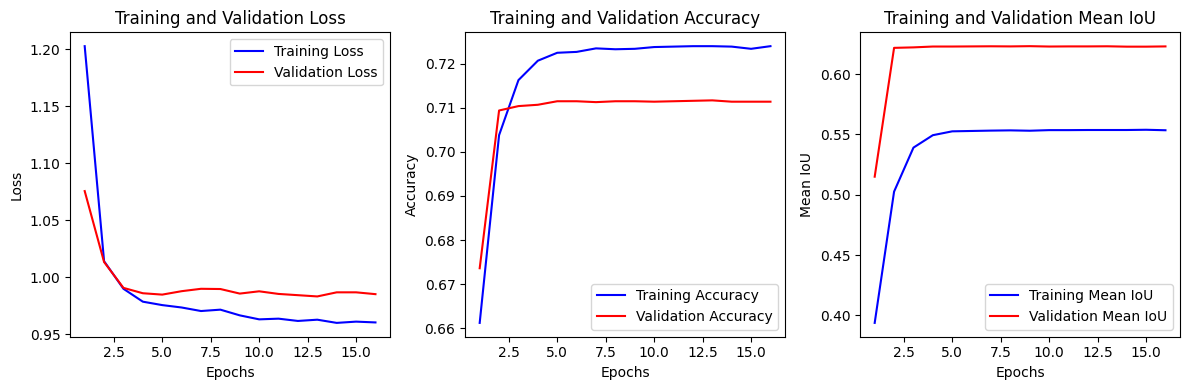

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()
plt.figure(figsize=(6, 6))
plt.plot(history4.history['mean_iou'])
plt.plot(history4.history['val_mean_iou'])
plt.title('Mean IoU')
plt.ylabel('Mean IoU')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()